# Align and annotate reads from 10X single-cell sequencing of influenza-infected cells
This notebook processes the raw sequencing data from the 10X sequencing. 

The data are from A549 (human) cells infected with influenza at low MOI and then harvested at various timepoints.
The influenza viruses themselves are a mix of a  _wildtype_ population and a _synonymously barcoded_ A/WSN/1933 (H1N1) virus.
The synonymously barcoded viruses have synonymous mutations near the 3' end of their mRNAs in order to enable them to be distinguished from the wildtype virus, thus quantifying the rate of cellular co-infection.

Much of the the data processing is done using the 10X software [cellranger](https://support.10xgenomics.com/single-cell/software/pipelines/latest/what-is-cell-ranger).
In some cases, custom scripts are used for non-standard steps relating to handling the influenza reads.

Specifically, this notebook performs the following operations:

   1. Builds a reference genome to which reads are aligned.
   2. De-multiplexes the reads using `cellranger`.
   3. Aligns the de-multiplexed reads to the reference genome to generate the cell-gene count matrix.
   4. Annotates the synonymous barcodes on the influenza reads.
   5. Gets all the results in a format that make them ready for downstream analysis with [Monocle](http://cole-trapnell-lab.github.io/monocle-release/).

## Set up notebook
Import modules used in this notebook.
The `pymodules.utils` module contains custom functions used for this analysis.

In [1]:
import os
import multiprocessing
import shutil
from IPython.display import Image, display
import pymodules.utils

print("Using following version of cellranger:")
!cellranger count --version

resultsdir = './results/'
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)
plotsdir = os.path.join(resultsdir, 'plots/')
if not os.path.isdir(plotsdir):
    os.mkdir(plotsdir)
    
maxcpus = min(15, multiprocessing.cpu_count()) # max number of CPUs to use at once    

Using following version of cellranger:
cellranger count (2.0.0)
Copyright (c) 2017 10x Genomics, Inc.  All rights reserved.
-------------------------------------------------------------------------------

 


## Define information about the experimental samples and sequencing runs
We have the following samples.
All of these samples used a mix of wildtype and synonymously barcoded viruses that were passaged at low MOI for a limited amount of time, and so should contain relatively "high-purity" viruses. 
There are two independent mixes of these viruses referred to as *sample 1* and *sample 2*. 
We don't have a complete set for either sample as some runs failed. All samples were washed at 1-hour post-infection unless otherwise noted:

  1. *Uninfected*: untreated A549 cells.
  2. *6hr-1*: A549 cells infected with sample 1 of "high-purity" mix of wildtype and synonymously barcoded influenza, collected at 6 hours post-infection.
  3. *8hr-2*: A549 cells infected with sample 2 of "high purity" mix, collected at 8 hours post-infection.
  4. *10hr-2*: like *8hr-2* but collected at 10 hours post-infection. 
  5. *8hr-2repeat*: a second run of *8hr-2*, but unlike all other samples the cells were **not** washed after viral infection. The washing possibly is not of any relevance anyway, but this is not known for sure.

In [2]:
samples = ['Uninfected', '6hr-1', '8hr-2', '8hr-2repeat', '10hr-2']

These samples were sequenced over several different Illumina runs, which are listed in `seqruns` below. 
These runs sequence the entire transcriptome of cellular and influenza genes, and so (hopefully) are an unbiased representation of the mRNAs (at least as unbiased as the 10X protocol can be).

We also have some extra sequencing that attempts to **only** sequence the influenza genes after enriching them by semi-specific PCR. 
This extra sequencing is done in a different run.
It definitely is **not** an unbiased representation of what is present, as some influenza genes were clearly enriched much better than others.
However, this extra sequencing is useful for annotating the influenza synonymous barcodes, so it is processed for that purpose but **not** used to build up the cell-gene count matrix.
The extra influenza-specific sequencing runs are listed in `extraflu_seqruns` below.

Below we define both types of sequencing runs, the BCL directories for each run, and the samples and indices for each run.

In [3]:
seqruns = ['2016-12-12', '2017-01-20'] # sequencing runs for entire cellular + influenza transcriptome

extraflu_seqruns = ['2017-05-18'] # runs just enriching in influenza reads by semi-specific PCR

bcl_dir = '/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/' 
bcl_dirs = {
        '2016-12-12':os.path.join(bcl_dir, '161212_SN367_0838_AH7LFLBCXY.bcl/'),
        '2017-01-20':os.path.join(bcl_dir, '170120_D00300_0374_BHFGJLBCXY/'),
        '2017-05-18':os.path.join(bcl_dir, '170518_M03100_0234_000000000-B5R5C/')
        }
assert set(bcl_dirs.keys()) == set(seqruns + extraflu_seqruns)
flow_cells = {
        '2016-12-12':'H7LFLBCXY',
        '2017-01-20':'HFGJLBCXY',
        '2017-05-18':'B5R5C',
        }
assert set(flow_cells.keys()) == set(bcl_dirs.keys())

bcl_samplesheets = {
        '2016-12-12':'''Lane, Sample           , Index
                           1, Uninfected       , SI-3A-A8
                           2, Uninfected       , SI-3A-A8
                           1, 6hr-1            , SI-3A-A9
                           2, 6hr-1            , SI-3A-A9
                           1, 8hr-2            , SI-3A-A11
                           2, 8hr-2            , SI-3A-A11
                           1, 8hr-2repeat      , SI-3A-A7
                           2, 8hr-2repeat      , SI-3A-A7
                           1, 10hr-2           , SI-3A-A12
                           2, 10hr-2           , SI-3A-A12
                     '''.replace(' ', ''),
        '2017-01-20':'''Lane, Sample           , Index
                           1, Uninfected       , SI-3A-A8
                           2, Uninfected       , SI-3A-A8
                           1, 8hr-2            , SI-3A-A11
                           2, 8hr-2            , SI-3A-A11
                           1, 10hr-2           , SI-3A-A12
                           2, 10hr-2           , SI-3A-A12
                     '''.replace(' ', ''),
        '2017-05-18':'''Lane, Sample           , Index
                           1, 6hr-1            , SI-3A-C1
                           1, 8hr-2            , SI-3A-C3
                           1, 8hr-2repeat      , SI-3A-C2
                           1, 10hr-2           , SI-3A-C4
                     '''.replace(' ', ''),
        }
assert set(bcl_samplesheets.keys()) == set(seqruns + extraflu_seqruns)

seqruns_for_sample = {}
extraflu_seqruns_for_sample = {}
for seqrun in seqruns + extraflu_seqruns:
    csvtext = bcl_samplesheets[seqrun]
    samplesforseqrun = [line.split(',')[1].strip() for line in csvtext.splitlines()[1 : ]]
    if seqrun in seqruns:
        d = seqruns_for_sample
    else:
        d = extraflu_seqruns_for_sample
    for x in set(samplesforseqrun):
        assert x in samples, "Invalid sample {0}".format(x)
        if x not in d:
            d[x] = set([seqrun])
        else:
            d[x].add(seqrun)
            
for sample in samples:
    print("Sequenced {0} in the following {1} runs: {2}".format(sample,
            len(seqruns_for_sample[sample]), ', '.join(seqruns_for_sample[sample])))
    if sample in extraflu_seqruns_for_sample:
        print("Also sequenced {0} in the following {1} extra-flu runs: {2}".format(sample,
                len(extraflu_seqruns_for_sample[sample]), ', '.join(extraflu_seqruns_for_sample[sample])))

Sequenced Uninfected in the following 2 runs: 2016-12-12, 2017-01-20
Sequenced 6hr-1 in the following 1 runs: 2016-12-12
Also sequenced 6hr-1 in the following 1 extra-flu runs: 2017-05-18
Sequenced 8hr-2 in the following 2 runs: 2016-12-12, 2017-01-20
Also sequenced 8hr-2 in the following 1 extra-flu runs: 2017-05-18
Sequenced 8hr-2repeat in the following 1 runs: 2016-12-12
Also sequenced 8hr-2repeat in the following 1 extra-flu runs: 2017-05-18
Sequenced 10hr-2 in the following 2 runs: 2016-12-12, 2017-01-20
Also sequenced 10hr-2 in the following 1 extra-flu runs: 2017-05-18


## Build the reference genome
We need a non-standard reference genome.
Specifically, we expect two kinds of cells:

   1. plain A549 (human) cells,
   
   2. A549 cells infected with the WSN strain of influenza.
   
We therefore use `cellranger mkref` [to build a custom reference genome]( https://support.10xgenomics.com/single-cell/software/pipelines/latest/advanced/references). 
This reference genome is the concatenation of the human and influenza genomes, since we expect both human and viral mRNAs to be found in the same cell.
We do **not** worry about including both the wildtype and synonymously barcoded influenza genomes, since the `cellranger` aligner seems sufficiently permissive that it aligns both the barcoded and non-barcoded influenza reads to the wildtype genome -- therefore we only include the wildtype influenza genome.

The reference genome is built by `./scripts/mkrefgenome.bash`, which downloads the genomes from [ensembl](http://www.ensembl.org/index.html) and then runs `cellrangermkref`.
The resulting genome is named `humanplusflu` to reflect the fact that it consists of the concatenated human + influenza genomes.

In [4]:
refgenome = './humanplusflu/'
if not os.path.isdir(refgenome):
    print("Creating reference genome...")
    log = !./scripts/mkrefgenome.bash || rm -r {refgenome}
    assert os.path.isdir(refgenome), "Failed to make reference genome"
    print("Reference genome is in {0}".format(refgenome))
else:
    print("Using existing reference genome")

Using existing reference genome


## De-multiplex the deep sequencing reads
Next, we de-multiplex the deep sequencing reads from the BCL output of the Illumina sequencer to FASTQ files using `cellranger mkfastq` as [described here](https://support.10xgenomics.com/single-cell/software/pipelines/latest/using/mkfastq).

De-multiplexed reads for 2016-12-12 already in ./results/demultiplexed_reads/2016-12-12


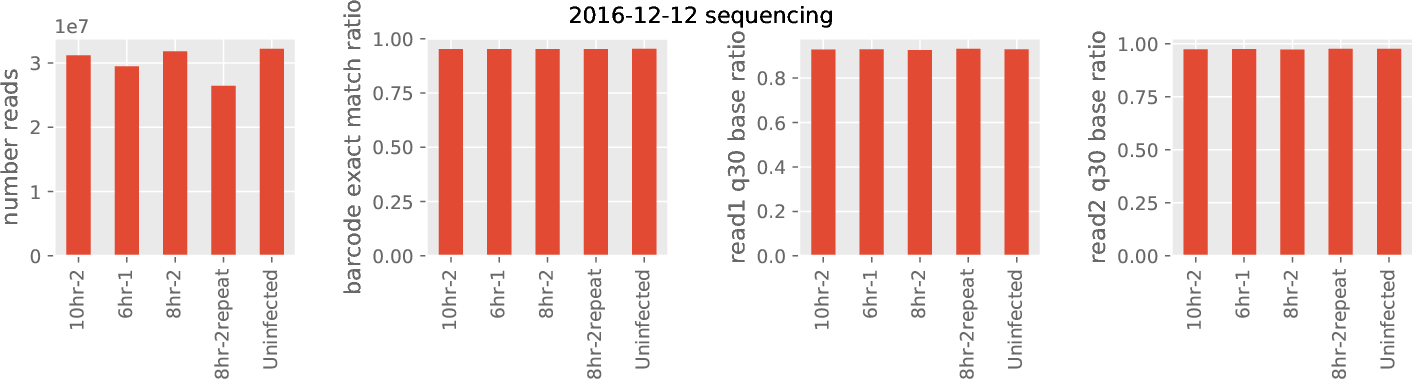

De-multiplexed reads for 2017-01-20 already in ./results/demultiplexed_reads/2017-01-20


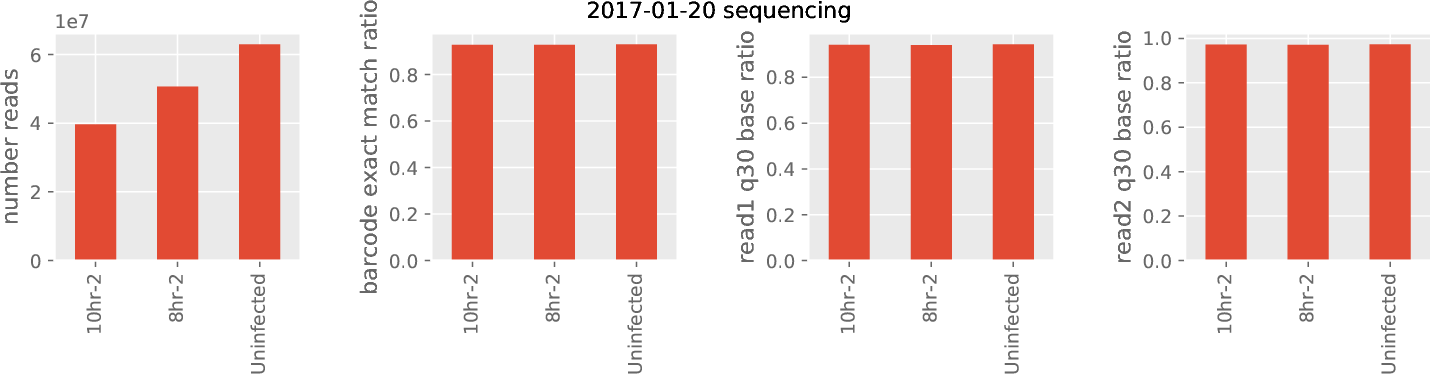

De-multiplexed reads for 2017-05-18 already in ./results/demultiplexed_reads/2017-05-18


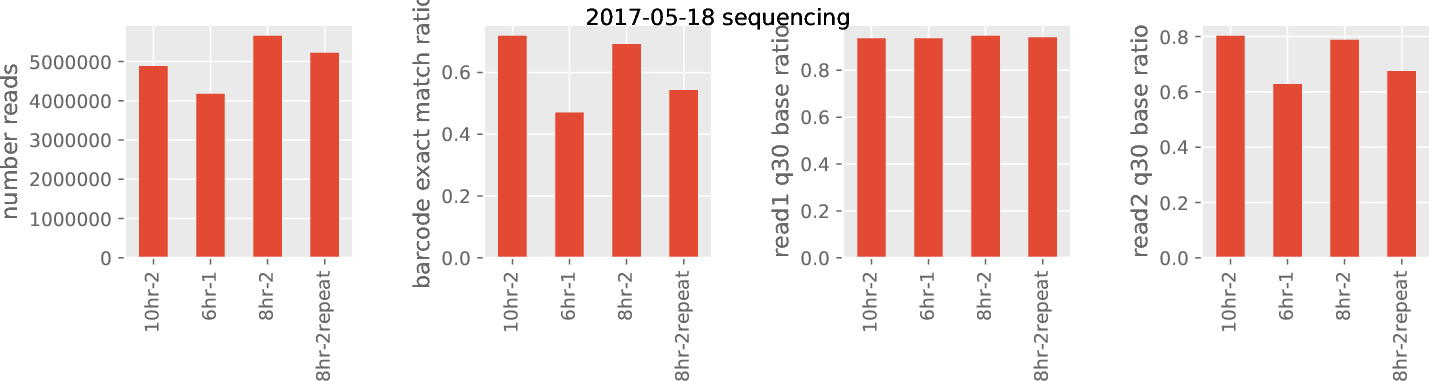

All de-multiplexing is complete.


In [5]:
demuxdir = os.path.join(resultsdir, 'demultiplexed_reads/')
if not os.path.isdir(demuxdir):
    os.mkdir(demuxdir)

for seqrun in seqruns + extraflu_seqruns:
    outdir = os.path.join(demuxdir, seqrun)
    qcplot = os.path.join(plotsdir, '{0}_demux.pdf'.format(seqrun))
    if os.path.isdir(outdir):
        print("De-multiplexed reads for {0} already in {1}".format(seqrun, outdir))
    else:
        print("De-multiplexing {0} into {1}...".format(seqrun, outdir))
        samplesheet = os.path.join(demuxdir, '{0}_samplesheet.csv'.format(seqrun))
        with open(samplesheet, 'w') as f:
            f.write(bcl_samplesheets[seqrun])
        flowcell = flow_cells[seqrun]
        mro = '__{0}.mro'.format(flowcell)
        # run cellranger, move output files to outdir, delete output if command files
        log = !(cellranger mkfastq --run={bcl_dirs[seqrun]} --output-dir={outdir} \
                --csv={samplesheet} --project=fastq && mv {mro} {outdir} && \
                mv {flowcell} {outdir}/pipestance) || \
                (rm -r {outdir} && rm {mro} rm -r {flowcell})
    qc = os.path.join(outdir, 'pipestance/outs/qc_summary.json')
    if not os.path.isfile(qcplot):
        pymodules.utils.demuxSummary(qc, qcplot, '{0} sequencing'.format(seqrun))
    pymodules.utils.showPDF(qcplot)
    
print("All de-multiplexing is complete.")

The plots above summarize the de-multiplexing.
For all of these samples, the barcode match and Q30 values look good, so sequencing itself seems successful.

## Align the reads and count the genes per cell
We use `cellranger count` to align the reads to the reference genome for each sample and classify the reads into cells.
Because our samples are spread over multiple flow cells, we have to use MRO files to tell `cellranger` to combine these [as described here](https://support.10xgenomics.com/single-cell/software/pipelines/latest/advanced/multi-flowcell).

We also copy the resulting cell-gene counts to a separate subdirectory so that they are easy to find and modify subsequently below.

Finally, we print the links to the `cellranger` websummary pages, and make some plots summarizing the results.

At the same time, we also align the extra flu reads for each sample if they exist. 
However, no information is printed for these as they don't represent the actuall cell-gene counts for the sample, but just extra reads that will be used for calling the synonymous barcodes later.

Alignments and counts already created for Uninfected in ./results/./alignments_and_counts/Uninfected
The cellranger web summary for this Uninfected is in ./results/plots/cellranger_web_summary_Uninfected.html
Alignments and counts already created for 6hr-1 in ./results/./alignments_and_counts/6hr-1
The cellranger web summary for this 6hr-1 is in ./results/plots/cellranger_web_summary_6hr-1.html
Alignments for extra flu reads already created for 6hr-1 in ./results/./alignments_and_counts/6hr-1_extraflu
Alignments and counts already created for 8hr-2 in ./results/./alignments_and_counts/8hr-2
The cellranger web summary for this 8hr-2 is in ./results/plots/cellranger_web_summary_8hr-2.html
Alignments for extra flu reads already created for 8hr-2 in ./results/./alignments_and_counts/8hr-2_extraflu
Alignments and counts already created for 8hr-2repeat in ./results/./alignments_and_counts/8hr-2repeat
The cellranger web summary for this 8hr-2repeat is in ./results/plots/cellranger_web_summary

/home/jbloom/.local/lib/python2.7/site-packages/matplotlib/tight_layout.py:222: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


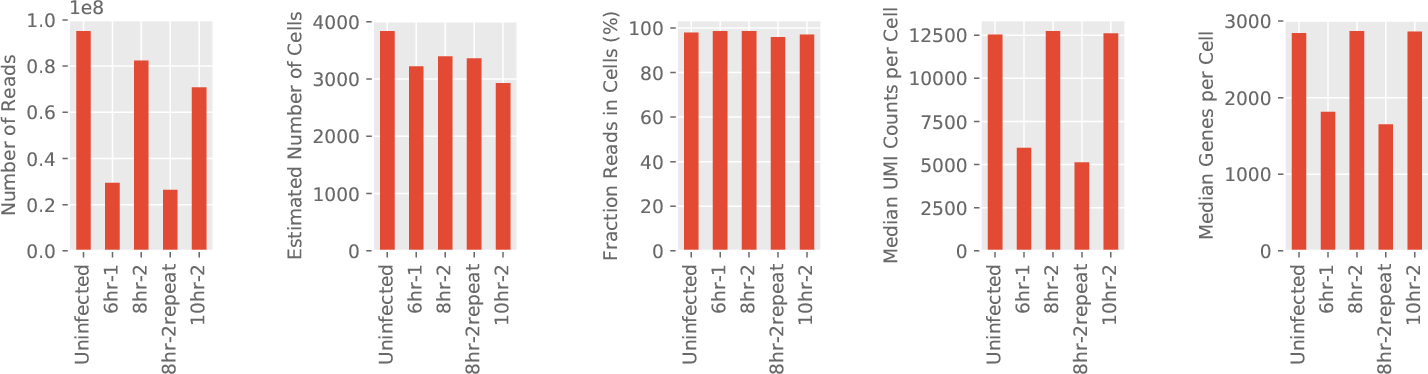

In [6]:
aligndir = os.path.join(resultsdir, './alignments_and_counts/')
if not os.path.isdir(aligndir):
    os.mkdir(aligndir)
    
countsdir = os.path.join(resultsdir, './cellgenecounts/')
if not os.path.isdir(countsdir):
    os.mkdir(countsdir)
      
alignmetrics = []
cellgene_d = dict([(ftype, {}) for ftype in ['matrix', 'genes', 'barcodes']])
counts = {} # directory with cellgenecounts for each sample
bamfiles = {} # BAM files for each sample, used to annotate synonymous barcodes
extraflu_bamfiles = {} # BAM files with extra flu reads for each sample

for sample in samples:
    
    # process the reads for the sample
    sample_demuxdirs = [os.path.join(demuxdir, seqrun, 'fastq') for 
            seqrun in seqruns_for_sample[sample]]
    outdir = os.path.join(aligndir, sample)
    websummary = os.path.join(plotsdir, 'cellranger_web_summary_{0}.html'.format(sample))
    if os.path.isdir(outdir):
        print("Alignments and counts already created for {0} in {1}".format(sample, outdir))
    else:
        print("Making alignments and counts for {0}...".format(sample))
        mro = '_{0}_cellrangercount.mro'.format(sample)
        with open(mro, 'w') as f:
            f.write(pymodules.utils.multiFlowCellMRO(sample, sample_demuxdirs, refgenome))
        log = !cellranger count {sample} {mro} --localcores={maxcpus} --nosecondary && mv {sample} {outdir} \
                && rm {mro}
        assert os.path.isdir(outdir)
        print("Alignments and counts for {0} now in {1}".format(sample, outdir))
    if not os.path.isfile(websummary):
        shutil.copy(os.path.join(outdir, 'outs', 'web_summary.html'), websummary)
    assert os.path.isfile(websummary), "Can't find {0}".format(websummary)
    print("The cellranger web summary for this {0} is in {1}".format(sample, websummary))
    bamfiles[sample] = os.path.join(outdir, 'outs/possorted_genome_bam.bam')
    counts[sample] = os.path.join(countsdir, sample)
    if not os.path.isdir(counts[sample]):
        os.mkdir(counts[sample])
    for f in ['matrix.mtx', 'genes.tsv', 'barcodes.tsv']:
        fullf = os.path.join(counts[sample], 'humanplusflu_{0}'.format(f))
        cellgene_d[os.path.splitext(f)[0]][sample] = fullf
        if not os.path.isfile(fullf):
            shutil.copy(os.path.join(outdir, 'outs', 'filtered_gene_bc_matrices', 
                    'humanplusflu', f), fullf)
    alignmetrics.append(os.path.join(outdir, 'outs', 'metrics_summary.csv'))

    # process any extra flu reads for the sample
    if sample not in extraflu_seqruns_for_sample:
        extraflu_bamfiles[sample] = '' # no extra flu reads for this sample
        continue
    extraflu_sample_demuxdirs = [os.path.join(demuxdir, seqrun, 'fastq') for seqrun in 
            extraflu_seqruns_for_sample[sample]]
    extraflu_outdir = os.path.join(aligndir, '{0}_extraflu'.format(sample))
    if os.path.isdir(extraflu_outdir):
        print("Alignments for extra flu reads already created for {0} in {1}".format(
                sample, extraflu_outdir))
    else:
        print("Aligning the extra flu reads for {0}...".format(sample))
        mro = '_{0}_extraflu_cellrangercount.mro'.format(sample)
        with open(mro, 'w') as f:
            f.write(pymodules.utils.multiFlowCellMRO(sample, 
                    extraflu_sample_demuxdirs, refgenome))
        log = !cellranger count {sample}_extraflu {mro} --localcores={maxcpus} --nosecondary && \
                mv {sample}_extraflu {extraflu_outdir} && rm {mro}
        assert os.path.isdir(extraflu_outdir)
        print("Alignments for extra flu reads for {0} now in {1}".format(sample, extraflu_outdir))
    extraflu_bamfiles[sample] = os.path.join(extraflu_outdir, 'outs/possorted_genome_bam.bam')

print("\nHere is a plot summarizing the results:")
countsummaryplot = os.path.join(plotsdir, 'align_and_count_summary.pdf')
pymodules.utils.countSummary(samples, alignmetrics, countsummaryplot)
pymodules.utils.showPDF(countsummaryplot)

These summaries show that all samples have between 3000 and 4000 cells, which is as expected.

We see that most reads successfully map to cells, and that the mean UMI counts per cell vary a bit, mostly based on sequencing depth per cell (there are more sequences per cell for some of the samples).

Overall, these summaries appear to indicate that everything worked well.

## Annotate synonymous barcodes on the influenza reads
The cells were infected with a mix of wildtype virus and virus carrying a synonymous barcode (two synonymous mutations) so that they would appear near the 3' end of the mRNA and frequently be read in the 10X sequencing.

However, the `cellranger` analysis does not annotate those barcodes, so we do that here with a custom Python script.

Below, we do this annotation **both** only with the reads from the 10X full-transcriptome sequencing, and with these reads plus the extra flu reads from the semi-specific PCR.
Note that only the former reads are assumed to be roughly unbiased among transcripts.

Synonymous barcodes on influenza reads already annotated for Uninfected
Synonymous barcodes on influenza reads already annotated for 6hr-1
Synonymous barcodes on influenza reads already annotated for 8hr-2
Synonymous barcodes on influenza reads already annotated for 8hr-2repeat
Synonymous barcodes on influenza reads already annotated for 10hr-2

Here are some summary plots:

Plot for whole-transcriptome sequencing


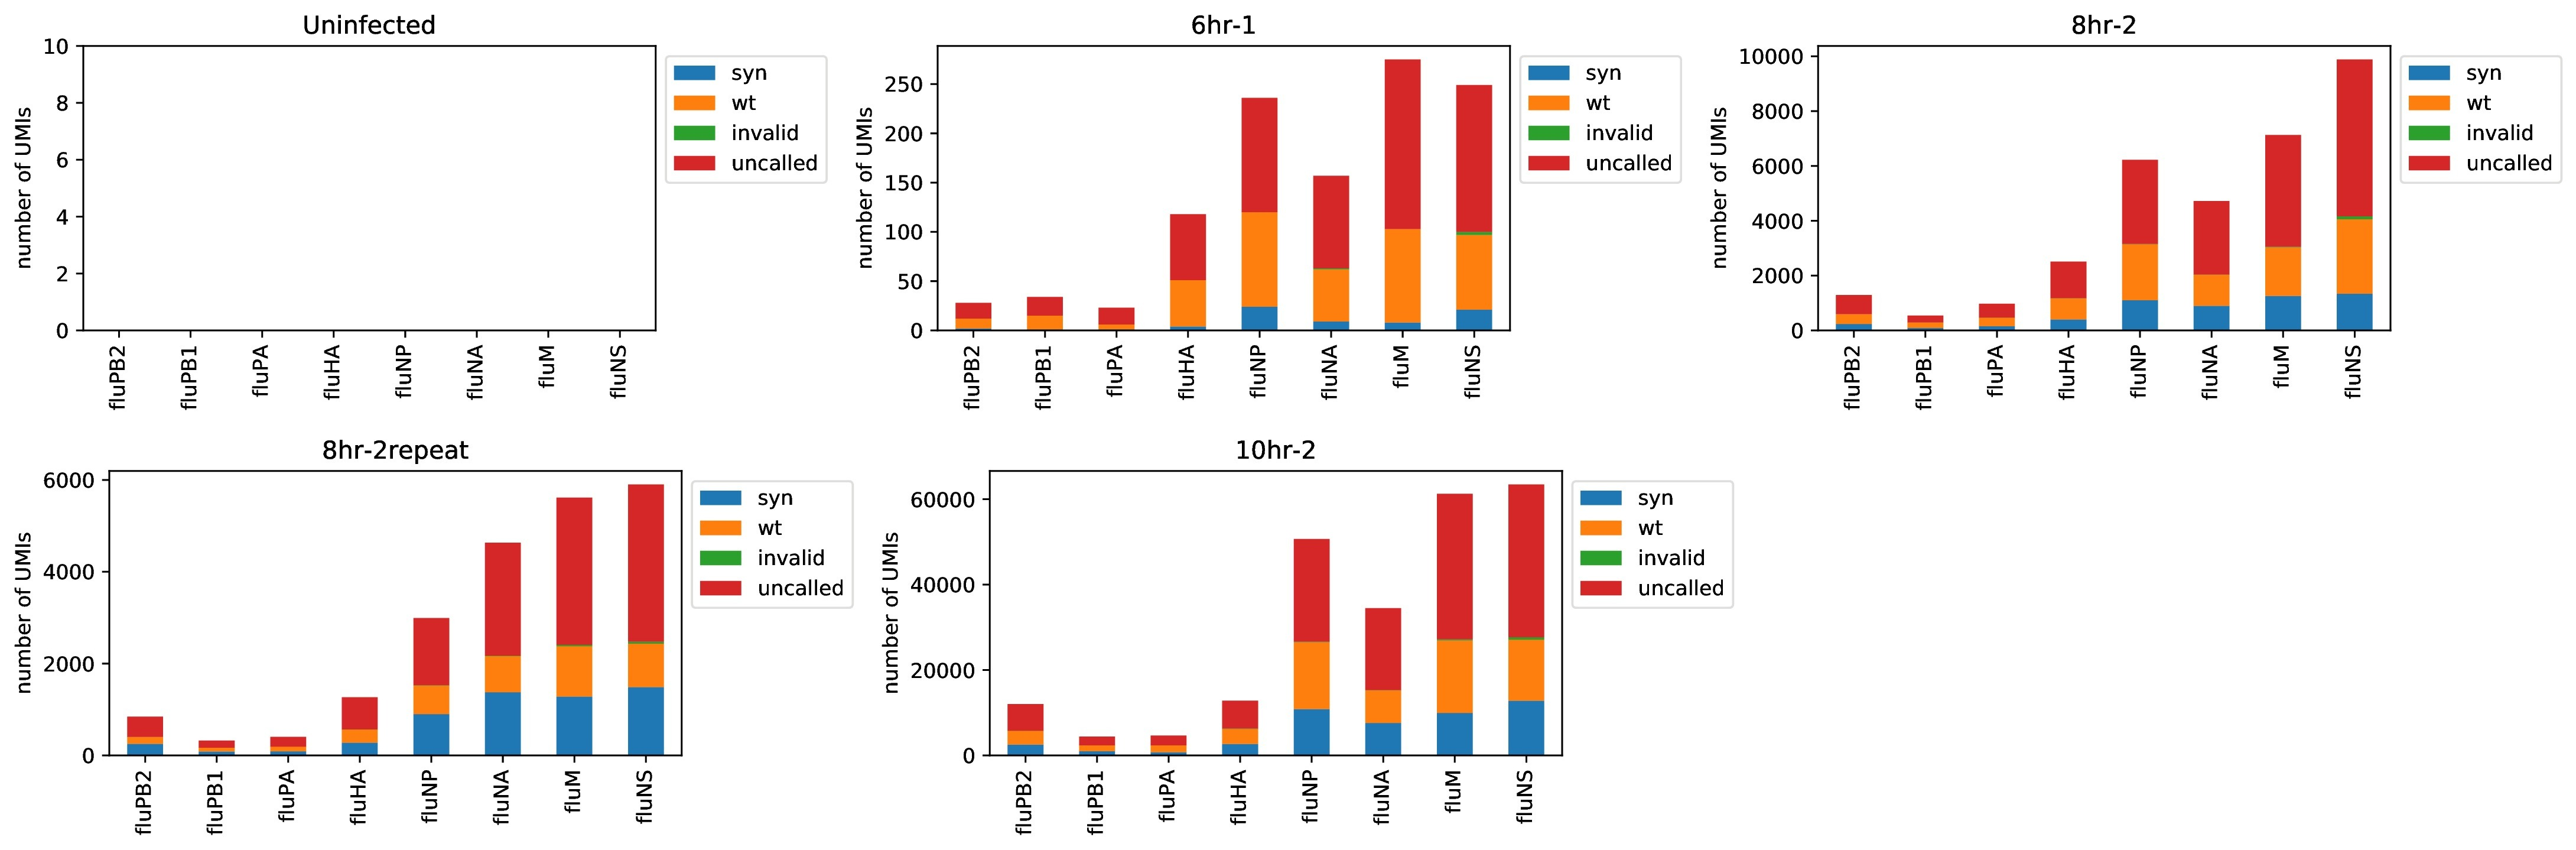


Plot for whole-transcriptome sequencing withextraflu


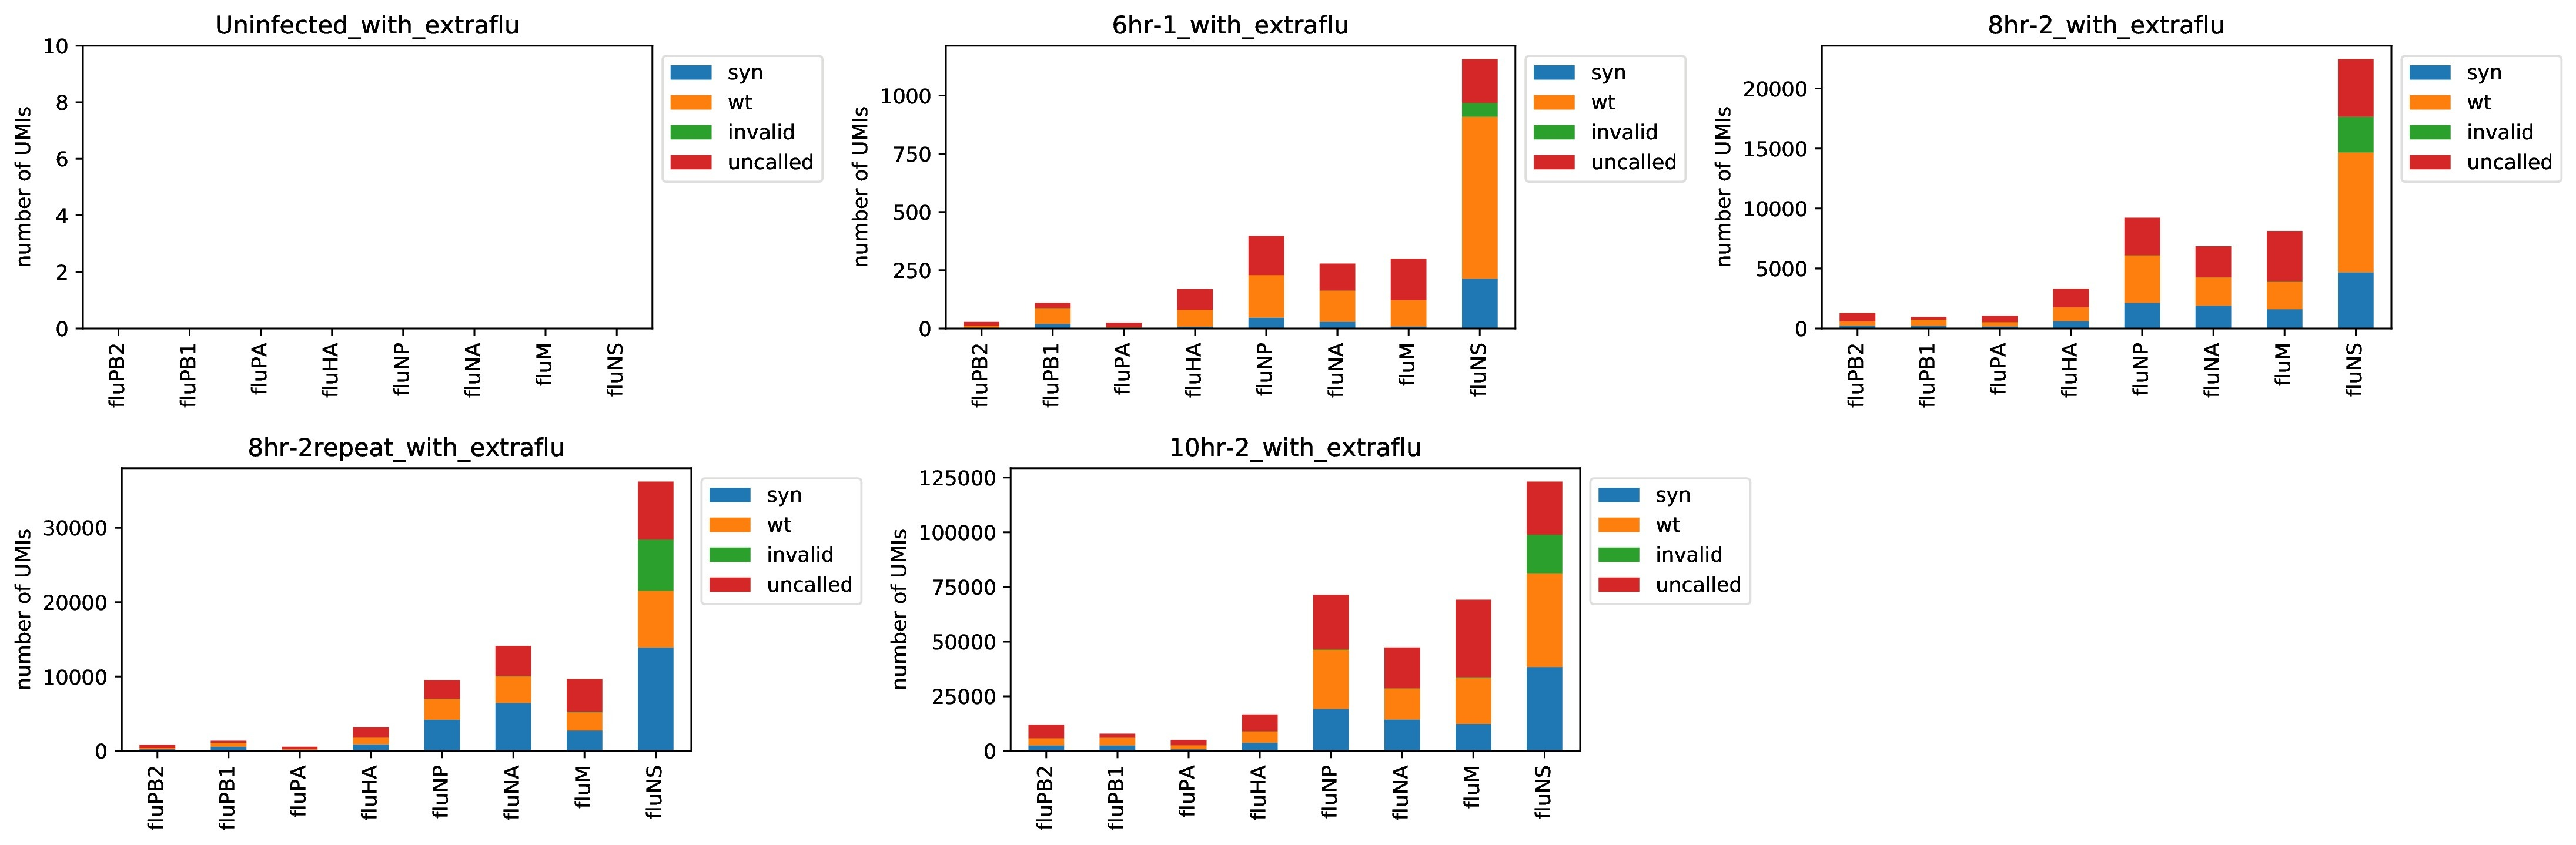


Plot for whole-transcriptome sequencing


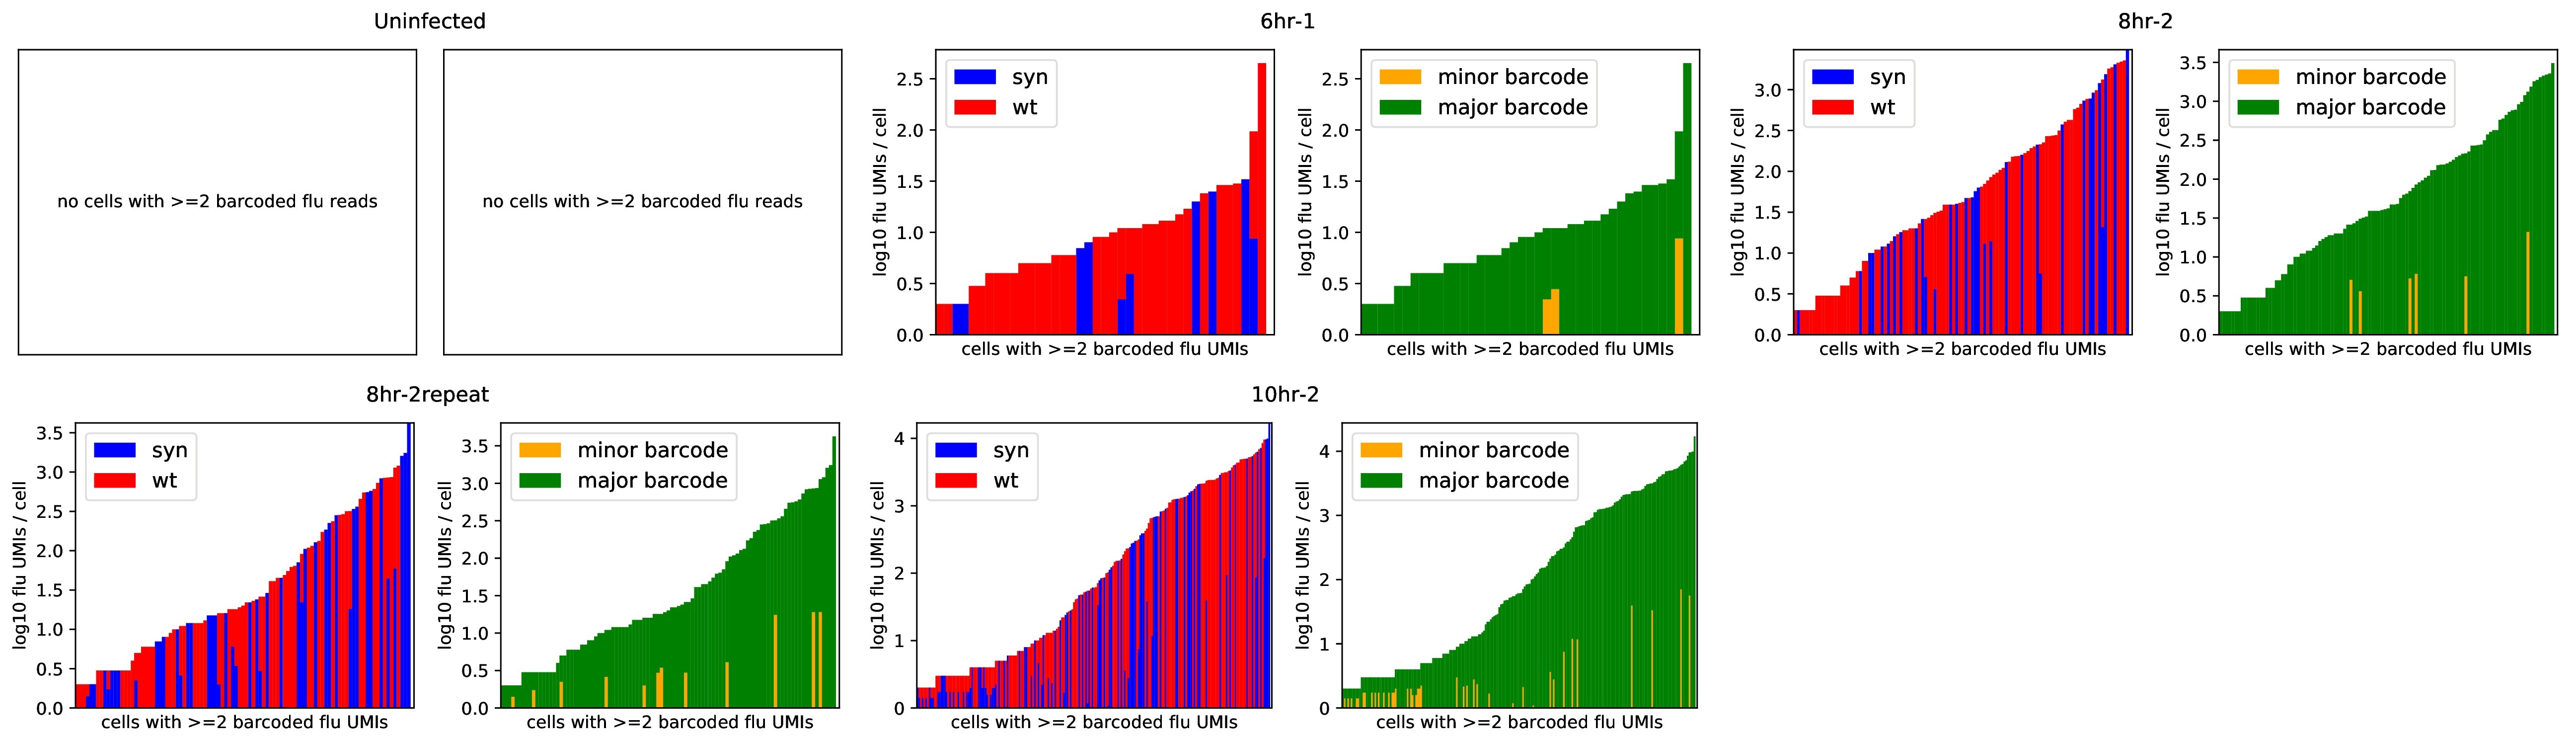


Plot for whole-transcriptome sequencing withextraflu


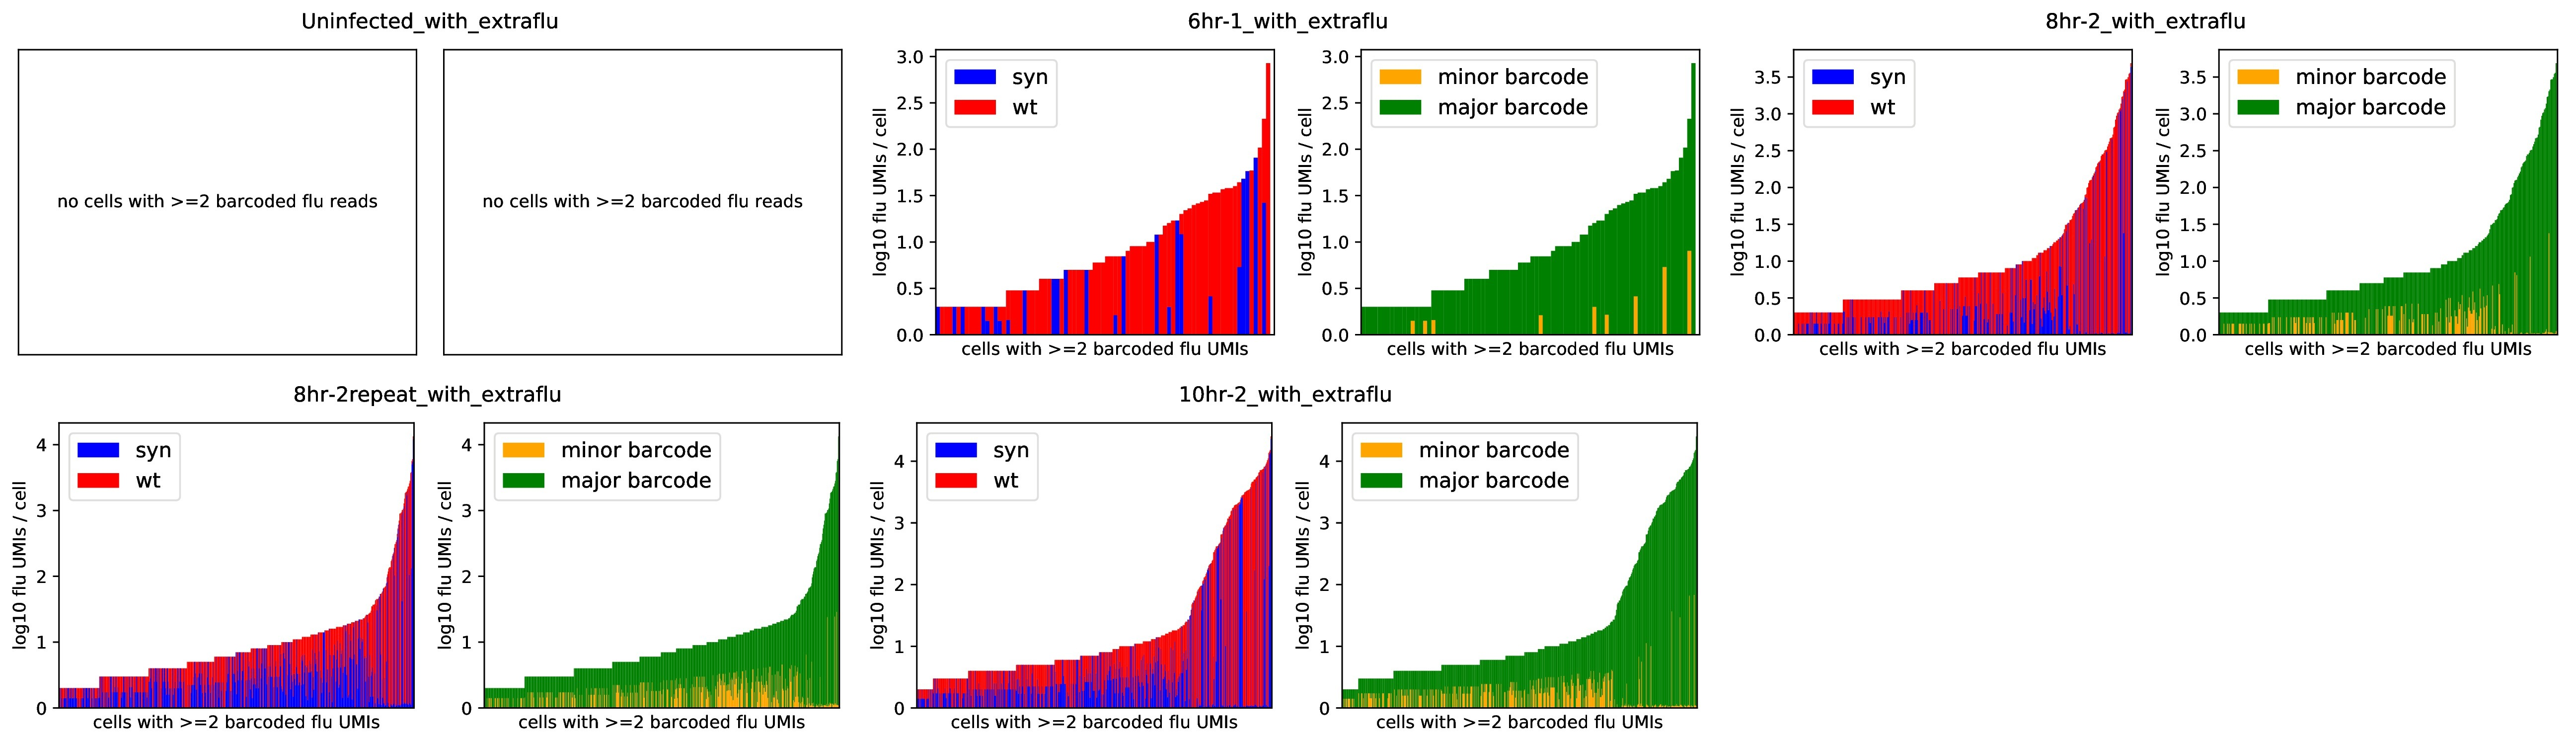

In [7]:
synbarcodeplots = os.path.join(plotsdir, './synbarcodes/')
if not os.path.isdir(synbarcodeplots):
    os.mkdir(synbarcodeplots)

cellgene_d['annotations'] = {} # save the annotations with the extra flu reads, as we use those for Monocle

for sample in samples:
    barcodes = os.path.join(counts[sample], 'humanplusflu_barcodes.tsv')
    annotations = os.path.join(counts[sample], 'humanplusflu_cellannotations.tsv')
    cellgene_d['annotations'][sample] = annotations
    outprefix = os.path.join(synbarcodeplots, '{0}_'.format(sample))
    extraflu_outprefix = os.path.join(synbarcodeplots, '{0}_withextraflu_'.format(sample))
    if os.path.isfile(annotations):
        print("Synonymous barcodes on influenza reads already annotated for {0}".format(sample))
    else:
        print("Annotating synonymous barcodes on influenza reads for {0}".format(sample))
        log = !python scripts/annotate_synbarcodes.py --flugenes \
                data/flu_sequences/flu-wsn.fasta --synflugenes \
                data/flu_sequences/flu-wsn-syn.fasta --samplename {sample} \
                --outprefix {outprefix} --cellbarcodes {barcodes} --bamfiles \
                {bamfiles[sample]} 
        log = !python scripts/annotate_synbarcodes.py --flugenes \
                data/flu_sequences/flu-wsn.fasta --synflugenes \
                data/flu_sequences/flu-wsn-syn.fasta --samplename {sample}_with_extraflu \
                --outprefix {extraflu_outprefix} --cellbarcodes {barcodes} \
                --bamfiles {bamfiles[sample]} {extraflu_bamfiles[sample]} \\
                && mv {extraflu_outprefix}cellannotations.tsv {annotations}
    assert os.path.isfile(annotations), "Can't find {0}".format(annotations)

print("\nHere are some summary plots:")
for plot in ['umistats', 'purity']:
    for extra in ['', '_withextraflu']:
        print("\nPlot for whole-transcriptome sequencing{0}".format(extra.replace('_', ' ')))
        outplot = os.path.join(plotsdir, 'synbarcodes{0}_{1}.jpg'.format(extra, plot))
        pymodules.utils.tilePlots([os.path.join(synbarcodeplots, '{0}{1}_{2}.pdf'.format(
            sample, extra, plot)) for sample in samples], outplot, ncols=3)
        display(Image(outplot))

From these plots we see several things:

  1. First, we are able to call the synonymous barcodes in about half of the influenza UMIs from just the 10X whole-transcriptome sequencing. This is about as expected -- sometimes these barcodes won't be overlapped by the Illumina read, and so won't be callable. The fraction of UMIs for which we can call the barcodes goes up when we include the extraflu reads. This also makes sense: these reads were longer, plus with them some of the UMIs are covered more.
  
  2. The number of influenza UMIs is about as expected. These numbers are zero for the *Uninfected* cells, very low for the *6hr* infection, low for the *8hr* infections, and moderate for the *10hr* infection.
  
  3. In all populations, we find a mix of the wildtype and synonymous barcoded viruses. In cells with low numbers of reads, these are about equal in frequency indicating that we are just seeing leakage. But in cells with more reads, the cells are mostly of one type or the other -- indicating that the actual rate of co-infection is low.
  
  4. The extraflu sequencing does **not** get all segments equally. It is highly biased towards NS, although it also does increase coverage of some additional genes as well. This is something Alistair has already noted using different approaches, and indicates that the semi-specific PCR works much better for NS than for most other segments.

## Build merged cell-gene matrix suitable for loading into Monocle
We merge all of the samples into a single cell-gene matrix file, and also make merged genes and ccell annotation files giving the rows and columns.
These cell-gene matrices and their annotations are appropriate for analysis with `Monocle`.

Note that the cell-gene matrices are built **only** on the whole-transcriptome 10X sequencing, but the annotations include the extra-flu.
The idea here is that the annotations could be helpful for identifying co-infection, so we want as much annotated information as possible about the wildtype versus synonymous barcoded variants -- therefore we include the extraflu reads for this annotation.
However, the extraflu reads are highly biased as to which segments they are derived from, and so don't represent a good way to generate actual transcript counts, and so should not be in the cell-gene matrices.

In [8]:
print("Building cell-gene matrix that merges all samples...")
mergedcounts = dict([(os.path.splitext(ftype)[0], os.path.join(countsdir, 
        'merged_humanplusflu_{0}'.format(ftype))) 
        for ftype in ['genes.tsv', 'cells.tsv', 'matrix.mtx']])
if all(map(os.path.isfile, mergedcounts.values())):
    print("The merged files already exist: {0}".format(', '.join(mergedcounts.values())))
else:
    pymodules.utils.mergeCellGeneMatrices(
            mergedcounts['genes'],
            mergedcounts['cells'],
            mergedcounts['matrix'],
            samples,
            cellgene_d['barcodes'],
            cellgene_d['annotations'],
            cellgene_d['genes'],
            cellgene_d['matrix'],
            )
    assert all(map(os.path.isfile, mergedcounts.values()))
    print("Created merged files: {0}\n".format(', '.join(mergedcounts.values())))

Building cell-gene matrix that merges all samples...
The merged files already exist: ./results/./cellgenecounts/merged_humanplusflu_cells.tsv, ./results/./cellgenecounts/merged_humanplusflu_genes.tsv, ./results/./cellgenecounts/merged_humanplusflu_matrix.mtx
